# Topic Modeling

<a href="https://mybinder.org/v2/gh/AllenWLynch/MIRA/HEAD?labpath=docs%2Fsource%2Fnotebooks%2Ftutorial_topic_model_tuning_full.ipynb">
    <img src="https://mybinder.org/badge_logo.svg" style="float:left; margin-top:20px">
</a>
<br><br>


## What is a topic model?

Topic models, like [LDA](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf), have traditionally been used to decompose a corpus of text into topics - or themes - composed of words that often appear together in documents. Documents, in turn, are modeled as a mixture of topics based on the words they contain. 

MIRA extends these ideas to single-cell genomics data, where topics are groups of genes that are co-expressed or *cis*-regulatory elements that are co-accessible, and cells are a mixture of these regulatory modules. The topics can be used for enrichment and pathway analysis, while the cells' topic mixtures can be used to embed the cells in an informative, interpretable latent space.

## Tuning and training

In this tutorial, we will cover tuning and training MIRA topic models to find the best hyperparameters for a given dataset. Single-cell datasets vary widely in terms of quality and complexity, and as such, no set of hyperparameters will ensure an optimal model in all cases. The most important parameter to optimize for a given dataset is the number of topics captured by the model, which represents units of covarying genes or *cis*-regulatory regions. The number of topics determines the quality of the embedding manifold and veracity of the topics' functional enrichments, so we recommend rigourous tuning to provide an accurate and informative analysis. 

MIRA topic model tuning proceeds in three stages:
  
1. Bayesian optimization of model hyperparameters on training set of cells
2. Model selection on validation set of cells
3. Final model training on whole dataset

**The first stage may be parallelized to speed up the process, and results from each stage may be visualized and compared using Tensorboard!**

Let's start by importing some packages:

In [1]:
import mira
import anndata
import scanpy as sc
mira.utils.pretty_sderr()

And we'll load some data. To make the tutorial quick, I've imported a synthetic single-cell dataset used as part of benchmarking MIRA's abilities in manifold and pseudotime trajectory inference. This synthetic dataset contains 1000 cells measured with both RNA and ATAC-seq mixed from the reads of real single cells from reference experiment.

In [2]:
mira.datasets.FrankenCell_RNA() # fetches dataset from cistrome.org
data = anndata.read_h5ad('mira-datasets/Frankencell_RNA.h5ad')

INFO:mira.datasets.datasets:Dataset already on disk.
INFO:mira.datasets.datasets:Dataset contents:
	* mira-datasets/Frankencell_RNA.h5ad


## Expression model preprocessing

**All of MIRA's models have the same API for instantiating, tuning, and training, regardless of mode.** This tutorial covers tuning of an expression topic model.

MIRA's topic models take raw counts as input, but we must first perform mode specific feature selection. For expression data, this is akin to highly variable gene selection in PCA, and ensures the model is using the best genes to learn topics.

To begin, we must first define two genesets:

* endogenous: genes which will be used as features for the topic model encoder network, usually ~2000 of the most variable genes
* exogenous: genes which will be captured in topics, a superset of the endogenous genes, a less stringent collection of genes which show some variable expression but perhaps not enough to be informative to the encoder network. 

We can form these genesets using [scanpy](https://scanpy.readthedocs.io/en/stable/tutorials.html) preprocessing functions, as shown below.

First, filter very rare genes, and freeze the raw counts:

In [3]:
sc.pp.filter_genes(data, min_cells=15)
data.raw = data

Normalize the read depths of each cell, then logarithmize the data:

In [4]:
sc.pp.normalize_total(data, target_sum=1e4)
sc.pp.log1p(data)

Calculate highly variable genes, but with a less stringent dispersion threshold. This set of genes will be our "exogenous" genes:

In [5]:
sc.pp.highly_variable_genes(data, min_disp = 0.2)
data.var['exog'] = data.var.highly_variable.copy()

Finally, calculate the "endogenous" geneset by intersecting the exogenous set with genes with a higher dispersion threshold:

In [6]:
data.var['endog'] = data.var.exog & (data.var.dispersions_norm > 0.7)

Restore the raw counts to the `counts` layer.

In [7]:
data.layers['counts'] = data.raw.to_adata().X.copy()

## Model setup

Next, we will instantiate an expression topic model. The hyperparameters will be tuned in the following stage, so all we have to worry about is telling the topic model how to access the genesets we just defined. 

In [8]:
model = mira.topics.ExpressionTopicModel(
    endogenous_key='endog', 
    exogenous_key='endog', 
    counts_layer='counts',
    seed = 0,
    hidden=64, # to make the tutorial faster. In practice, use the default of 128!
)

We must next set the learning rates for model. MIRA uses a training scheme where we must define the upper and lower bounds of the learning rate. `get_learning_rate_bounds` runs an array of learning rates to find the values for which the model is most responsive.

In [9]:
model.get_learning_rate_bounds(data, eval_every=1, upper_bound_lr=5)

INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: endog
INFO:mira.adata_interface.topic_model:Using highly-variable genes from col: endog


Learning rate range test:   0%|          | 0/88 [00:00<?, ?it/s]

INFO:mira.topic_model.base:Set learning rates to: (0.002239301508654534, 0.7206732647016323)


(0.002239301508654534, 0.7206732647016323)

We can then plot the learning rate vs. loss graph using `plot_learning_rate_bounds`. One can see the upper and lower bounds on the learning rate defined by the black and red bars, respectively. Use the `trim_learning_rate_bounds` function to adjust the location of the bars until they tightly bound the part of the curve with the steepest slope.

**If you push the upper bound too high, the model is likely to experience gradient overflows. The upper bound works best *at* or *before* the point where the slope starts to level off.**

INFO:mira.topic_model.base:Set learning rates to: (0.021245901172073332, 0.34042194569972284)


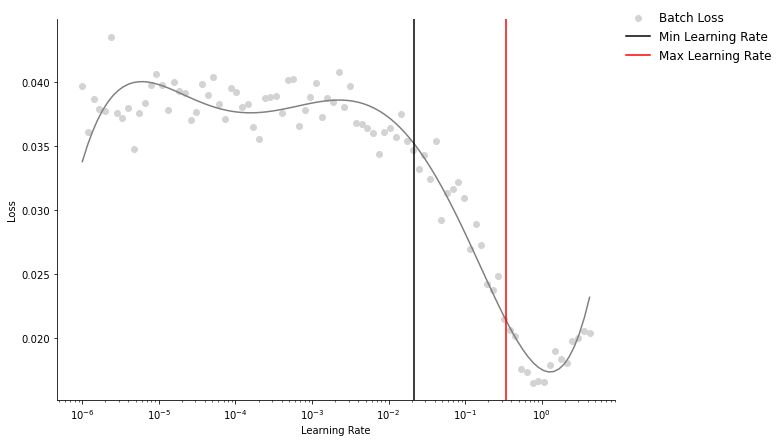

In [10]:
model.trim_learning_rate_bounds(2.25, 1.25)
_ = model.plot_learning_rate_bounds()

Now, we are ready to tune the model. Instantiate a [TopicModelTuner](../topicmodeling/mira.topics.TopicModelTuner.html) object, and pass the model to optimize. For repeatable results, pass a seed. Finally, give the tuning series a `save_name`. This will the be the name through which one can access and resume the tuning scheme. 

In [11]:
tuner = mira.topics.TopicModelTuner(
    model,  
    save_name = 'tuning-tutorial',
    seed = 0, 
    iters=32, # Recommend 30-64 iterations of tuning.
    max_topics = 15 # to speed up convergence! Leave at default of 55 when working with new data.
)

Use the tuner to split the data into train and test sets of cells:

In [12]:
tuner.train_test_split(data)

INFO:mira.adata_interface.topic_model:Added col: test_set
INFO:mira.adata_interface.core:Added cols to obs: test_set


### Side note: tensorboard integration

Results from hyperparameter tuning and training can be analyzed using [Tensorboard](https://www.tensorflow.org/tensorboard) during and after execution. Event files are stored in the execution directory under `runs/<save_name>`. `<save_name>` was defined on instantiation of the `TopicModelTuner` object.


#### Browser

One can either use the browser view via:

```
$ conda create --name tensorboard -y -c conda-forge tensorboard
$ conda activate tensorboard
$ tensorboard serve --logdir /path/to/workingdir/runs/<save_name>
```

#### Notebook widget

Or use the notebook widget to concurrently monitor training. Just start the tensorboard server before starting the tuning:

```
%load_ext tensorboard
%tensorboard --logdir runs/<save_name>
```

Topic model tuning will save scalars from each training run, hyperparameter selections and metrics, as well as embeddings to tensorboard's embedding projector. The board from this project can be viewed at https://tensorboard.dev/experiment/0yCvAnPJQqWZkSWQfGKArg/#hparams.

In [13]:
%load_ext tensorboard
%tensorboard --logdir runs/tuning-tutorial --port 6007

## Tuning

Now, start tuning! The expression topic model has few parameters, and can be trained on a CPU almost as fast as a GPU. Thus, this model can be tuned in parallel across as many cores as you can give it. When a GPU is available, all models will be mounted to partitions on the same GPU. To connect the same tuning process to multiple GPUs, one may start tuning schemes in separate processes. As long as the `TopicModelTuning` object is instantiated from the same directory with the same `save_name`, the separate processes will share history and work together to optimize the hyperparameters.

In [14]:
tuner.tune(data, n_workers=3)

Trials finished: 30 | Best trial: 24 | Best score: 4.7627e-01
Press ctrl+C,ctrl+C or esc,I+I,I+I in Jupyter notebook to stop early.

#Topics | Trials (number is #folds tested)
      5 | 1 5 1 
      6 | 5 5 1 5 1 5 
      7 | 2 5 2 
      8 | 1 1 5 5 
      9 | 0 5 5 4 
     10 | 5 
     11 | 5 1 
     12 | 1 5 
     13 | 2 
     14 | E 1 
     15 | 5 1 

Trial Information:
None
None
None
Trial #3   | completed, score: 4.7791e-01 | params: {'batch_size': 32, 'beta': 0.9383, 'encoder_dropout': 0.0693, 'kl_strategy': 'cyclic', 'num_epochs': 31, 'num_layers': 3, 'num_topics': 9}
Trial #4   | completed, score: 4.7738e-01 | params: {'batch_size': 32, 'beta': 0.9161, 'encoder_dropout': 0.0305, 'kl_strategy': 'cyclic', 'num_epochs': 21, 'num_layers': 2, 'num_topics': 8}
Trial #5   | completed, score: 4.8160e-01 | params: {'batch_size': 64, 'beta': 0.9177, 'encoder_dropout': 0.0689, 'kl_strategy': 'monotonic', 'num_epochs': 25, 'num_layers': 3, 'num_topics': 8}
Trial #6   | completed, score: 4

When the tuning is done, it will print out a dashboard that shows the sampling of the parameter space. The dashboard shows the distribution of topic numbers attempted. Tuning has completed when the tuning model appears to have converged on some number of topics that works well for your data.

Now we can move to stage 2 of the tuning scheme: *model selection*. The `select_best_model` command takes the top 5 models from the tuning stage and retrains them on the whole training set. Then, it assesses the model performance on the validation of cells. The best-performing model is retrained on the whole dataset.

In [15]:
tuner.select_best_model(data)

INFO:mira.topic_model.trainer:Training model with parameters: {'batch_size': 32, 'beta': 0.900101913203653, 'encoder_dropout': 0.033076936918757516, 'kl_strategy': 'monotonic', 'num_epochs': 30, 'num_layers': 2, 'num_topics': 12}


Epoch 0:   0%|          | 0/30 [00:00<?, ?it/s]

INFO:mira.topic_model.trainer:Score: 4.68221e-01


Predicting latent vars:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:mira.topic_model.trainer:Training model with parameters: {'batch_size': 32, 'beta': 0.9327614357972152, 'encoder_dropout': 0.06028008531364895, 'kl_strategy': 'monotonic', 'num_epochs': 29, 'num_layers': 2, 'num_topics': 10}


Epoch 0:   0%|          | 0/29 [00:00<?, ?it/s]

INFO:mira.topic_model.trainer:Score: 4.68149e-01


Predicting latent vars:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:mira.topic_model.trainer:Training model with parameters: {'batch_size': 32, 'beta': 0.9118785751199222, 'encoder_dropout': 0.014046057275203333, 'kl_strategy': 'monotonic', 'num_epochs': 23, 'num_layers': 2, 'num_topics': 6}


Epoch 0:   0%|          | 0/23 [00:00<?, ?it/s]

INFO:mira.topic_model.trainer:Score: 4.71571e-01


Predicting latent vars:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:mira.topic_model.trainer:Training model with parameters: {'batch_size': 32, 'beta': 0.9207713852366042, 'encoder_dropout': 0.0563216967241829, 'kl_strategy': 'cyclic', 'num_epochs': 22, 'num_layers': 3, 'num_topics': 6}


Epoch 0:   0%|          | 0/22 [00:00<?, ?it/s]

INFO:mira.topic_model.trainer:Score: 4.68201e-01


Predicting latent vars:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:mira.topic_model.trainer:Training model with parameters: {'batch_size': 32, 'beta': 0.9308437836435777, 'encoder_dropout': 0.04605549782636904, 'kl_strategy': 'cyclic', 'num_epochs': 30, 'num_layers': 3, 'num_topics': 15}


Epoch 0:   0%|          | 0/30 [00:00<?, ?it/s]

INFO:mira.topic_model.trainer:Score: 4.69024e-01


Predicting latent vars:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:mira.topic_model.trainer:Set parameters to best combination: {'batch_size': 32, 'beta': 0.9327614357972152, 'encoder_dropout': 0.06028008531364895, 'kl_strategy': 'monotonic', 'num_epochs': 29, 'num_layers': 2, 'num_topics': 10}
INFO:mira.topic_model.trainer:Training model with all data.
INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: endog
INFO:mira.adata_interface.topic_model:Using highly-variable genes from col: endog


Epoch 0:   0%|          | 0/29 [00:00<?, ?it/s]

INFO:mira.topic_model.base:Moving model to device: cpu


ExpressionTopicModel(
  (decoder): Decoder(
    (beta): Linear(in_features=10, out_features=2158, bias=False)
    (bn): BatchNorm1d(2158, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.2, inplace=False)
  )
  (encoder): ExpressionEncoder(
    (fc_layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=2159, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.06028008531364895, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=64, out_features=22, bias=True)
        (1): BatchNorm1d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
)

## Saving models

We have a tuned and trained topic model. Let's save it:

In [16]:
model.save('data/rna_topic_model.pth')

The model can be used for embedding cells in a low dimensional space and module analysis. We will discuss dimensionality reduction more in the next tutorial on **Making the Joint Representation**, but below I show the embedding of the synthetic cells matches the true scaffold.

Predicting latent vars:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Added key to uns: topic_dendogram
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


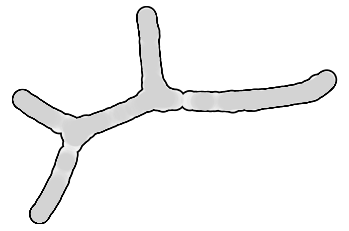

In [17]:
model.predict(data)
model.get_umap_features(data, box_cox=0.33)
sc.pp.neighbors(data, use_rep = 'X_umap_features', metric = 'manhattan')
sc.tl.umap(data, min_dist=0.1, negative_sample_rate=0.05)

sc.pl.umap(data, frameon=False, size = 1200, alpha = 0.2, add_outline=True,
          outline_width=(0.1,0))

## Accessibility model preprocessing

Unlike expression data, we do not prescribe a count processing method for accessibility data. The API for accessibility models is identical to expression topic models, so one may label some accessibility features (peaks) with endogenous or exogenous labels. 

In practice, we found that simply using all called peaks for both the endogenous and exogenous features produced good results. If one wishes to reduce model size, one may pursue alternate strategies for finding "highly variable" peaks to use as endogenous features.

To instantiate an accessibility topic model, use:

In [18]:
atac_model = mira.topics.AccessibilityTopicModel(counts_layer='counts')

From here, everything is **exactly** the same for tuning and training as it was with the expression model. The accessibility topic model has far more features and therefor far more parameters than the expression model. **It is highly recommended to train the accessibility model on a GPU.**

## Tuning persistence

Tuning results/trials/parameters are saved to a SQLite database in the working directory called "mira-tuning.db" (which can be changed through the `storage` parameter of the tuning object). Specific optimization runs are saved to their own tables, named by the `save_name` parameter. 

Thus, to resume tuning after an interuption, one must simply instantiate a tuning object with the same `storage` and `save_name` parameters as the previous process. The new object will reference the saved results and pick up where the last process left off.

To access the underlying [optuna study](https://optuna.readthedocs.io/en/stable/reference/study.html) directly:

In [19]:
study = mira.topics.TopicModelTuner.load_study('tuning-tutorial')

You could then print the dashboard summary by:

In [20]:
mira.topics.print_study(study)

Trials finished: 30 | Best trial: 24 | Best score: 4.7627e-01
Press ctrl+C,ctrl+C or esc,I+I,I+I in Jupyter notebook to stop early.

#Topics | Trials (number is #folds tested)
      5 | 1 5 1 
      6 | 5 5 1 5 1 5 
      7 | 2 5 2 
      8 | 1 1 5 5 
      9 | 0 5 5 4 
     10 | 5 
     11 | 5 1 
     12 | 1 5 
     13 | 2 
     14 | E 1 
     15 | 5 1 

Trial Information:
None
None
None
Trial #3   | completed, score: 4.7791e-01 | params: {'batch_size': 32, 'beta': 0.9383, 'encoder_dropout': 0.0693, 'kl_strategy': 'cyclic', 'num_epochs': 31, 'num_layers': 3, 'num_topics': 9}
Trial #4   | completed, score: 4.7738e-01 | params: {'batch_size': 32, 'beta': 0.9161, 'encoder_dropout': 0.0305, 'kl_strategy': 'cyclic', 'num_epochs': 21, 'num_layers': 2, 'num_topics': 8}
Trial #5   | completed, score: 4.8160e-01 | params: {'batch_size': 64, 'beta': 0.9177, 'encoder_dropout': 0.0689, 'kl_strategy': 'monotonic', 'num_epochs': 25, 'num_layers': 3, 'num_topics': 8}
Trial #6   | completed, score: 4

### Next

Please proceed to the next tutorial, which demonstrates how to stitch together a joint representation of cells measured using multiomics and two trained topic models.